# SI

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from matplotlib import style
import warnings

from PIL import Image, ImageFont, ImageDraw 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import cv2

### Global Settings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
style.use("ggplot")
SEED = 42
TEST_SIZE = 0.2
BATCH_SIZE = 500
np.random.seed(seed=SEED)

## Entendimiento

In [3]:
df = pd.read_csv("./dataset.csv") #dataset esta en la misma carpeta que este jupiter

### Preprocesamiento de datos

In [4]:
def move_data(df, TRAIN_BATCH = 0.8):
    
    df_covid = df[df.label == "COVID-19"]
    df_pneumonia = df[df.label == "pneumonia"]
    df_normal = df[df.label == "normal"]
    
    msk = np.random.rand(len(df_covid), ) < TRAIN_BATCH
    train_covid, test_covid = df_covid[msk], df_covid[~msk]

    msk = np.random.rand(len(df_pneumonia)) < TRAIN_BATCH
    train_penumonia, test_pneumonia = df_pneumonia[msk], df_pneumonia[~msk]

    msk = np.random.rand(len(df_normal)) < TRAIN_BATCH
    train_normal, test_normal = df_normal[msk], df_normal[~msk]
    
    train = pd.concat([train_covid, train_penumonia, train_normal])
    test = pd.concat([test_covid, test_pneumonia, test_normal])
    
    train["train"] = 1
    test["train"] = 0
    
    df = pd.concat([train,test])
    
    df.to_csv(r'./clean_dataframe.csv', index = False)
    
    from pathlib import Path

    for index, row in train.iterrows():
        Path('./data/{}'.format(row["filename"])).rename('./data/train/{}/{}'.format(row["label"],row["filename"]))
    for index, row in test.iterrows():
        Path('./data/{}'.format(row["filename"])).rename('./data/test/{}/{}'.format(row["label"],row["filename"]))
    
    return train, test

### Desarrollando el modelo

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, InputLayer, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [6]:
train_path = "./data/train"
test_path = "./data/test"
valid_path = "./data/valid"

train_batches = ImageDataGenerator( 
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True
    ).flow_from_directory(
        directory=train_path, 
        target_size=(224,224),
        batch_size=20)

test_batches = ImageDataGenerator( rescale=1./255 ).flow_from_directory(
    directory=test_path, 
    target_size=(224,224),
    batch_size=20)

valid_batches = ImageDataGenerator( rescale=1./255 ).flow_from_directory(
    directory=valid_path, 
    target_size=(224,224), 
    batch_size=20)

Found 9778 images belonging to 3 classes.
Found 3034 images belonging to 3 classes.
Found 2463 images belonging to 3 classes.


In [7]:
base_model = keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid')

In [8]:
#base_model = tf.keras.applications.MobileNetV2(
#    include_top = False,
#    weights = 'imagenet',
#    input_shape = (224,224,3),
#    classifier_activation = 'sigmoid')

In [9]:
# base_model.trainable = False

In [10]:
# base_model.summary()

In [11]:
# v.1
# max_poling_2d()
# conv2d(256, (1,1))
# Normalization
# Flatten
# Dropout(0.2)
# Dense(500)
# Dropout(0.2)
# Dense(120)
# Dropout(0.2)
# Dense(3,"softmax")
# optimizer = keras.optimizers.Adam(learning_rate=0.0005)


# v.2
# model = Sequential([
#    base_model,
#    tf.keras.layers.GlobalAveragePooling2D(),
#    Dense(3, "softmax")
#])
# optimizer = keras.optimizers.Adam(learning_rate=0.001)


In [12]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(3, "softmax")
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________


In [14]:
#optimizer = keras.optimizers.Adam(learning_rate=0.0008
optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
callback = keras.callbacks.ModelCheckpoint(
                    filepath='./models/model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}',
                    monitor='val_loss', 
                    verbose=1, 
                    save_best_only=True,
                    mode='auto')

In [16]:
history = model.fit_generator(
    train_batches,
    validation_data=valid_batches, 
    epochs = 30, 
    steps_per_epoch = 100, 
    verbose = 1,
    callbacks=[callback])

Epoch 1/30
100/100 [==============================] - 1167s 12s/step - loss: 0.5842 - accuracy: 0.7578 - val_loss: 0.8491 - val_accuracy: 0.7670

Epoch 00001: val_loss improved from inf to 0.84908, saving model to ./models/model.01-0.85-0.77
INFO:tensorflow:Assets written to: ./models/model.01-0.85-0.77/assets
Epoch 2/30
100/100 [==============================] - 1150s 12s/step - loss: 0.3672 - accuracy: 0.8685 - val_loss: 0.4207 - val_accuracy: 0.8685

Epoch 00002: val_loss improved from 0.84908 to 0.42070, saving model to ./models/model.02-0.42-0.87
INFO:tensorflow:Assets written to: ./models/model.02-0.42-0.87/assets
Epoch 3/30
100/100 [==============================] - 1150s 12s/step - loss: 0.3422 - accuracy: 0.8790 - val_loss: 0.3615 - val_accuracy: 0.8790

Epoch 00003: val_loss improved from 0.42070 to 0.36155, saving model to ./models/model.03-0.36-0.88
INFO:tensorflow:Assets written to: ./models/model.03-0.36-0.88/assets
Epoch 4/30
100/100 [==============================] - 11

In [17]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

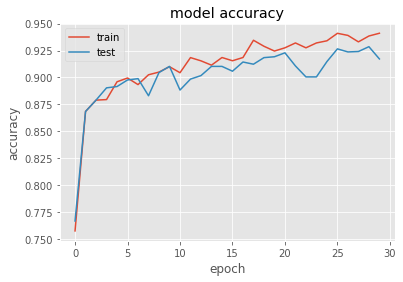

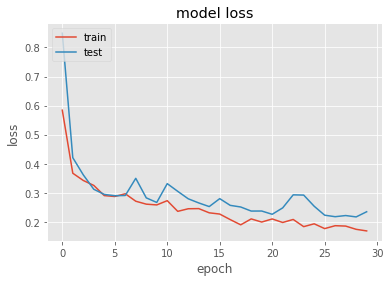

In [18]:
plot_accuracy(history)

In [18]:
testLoss, testAccuracy = model.evaluate(test_batches, verbose = 1)

print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

152/152 [==============================] - 316s 2s/step - loss: 0.2954 - accuracy: 0.8922
Accuracy of model : 89.22 %
Loss of model : 0.2954


In [31]:
model.save("./models/model-v.2-{}.h5".format(str(round(testAccuracy,4)*100) + ' %'))

### Analizando el modelo

In [4]:
model = load_model("./models/weights.31-0.23.hdf5")

ValueError: No model found in config file.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 1536)        0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 2, 2, 256)         393472    
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 256)         1024      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1025000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

In [12]:
testLoss, testAccuracy = model.evaluate(test_batches, verbose = 1)

print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

152/152 [==============================] - 373s 2s/step - loss: 0.2521 - accuracy: 0.9080
Accuracy of model : 90.8 %
Loss of model : 0.2521


In [ ]:
model = keras.load